In [1]:
# Carregando pacotes
%matplotlib inline
#!pip install ipywidgets~=7.0
#!pip install jupyter_contrib_nbextensions
#!pip install qrgrid
#!pip install pingouin
#!pip install missingno
import pygwalker as pyg
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np 
import seaborn as sns
import pingouin as pg
import missingno as msno
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.impute import KNNImputer

In [2]:
# Data wranglin
path = r"C:\Users\marce\OneDrive\Área de Trabalho\Desafio"
df1 = pd.read_csv(path + '\Estacao.csv')   #Brasilia
df2 = pd.read_csv(path + '\Sensor.csv')        #UTC

df2 = df2.rename(columns={"Datetime – utc": "data"})

df1['data'] = pd.to_datetime(df1['data']+' '+df1['Hora (Brasília)'],format = '%Y-%m-%d %H:%M:%S%z').dt.tz_localize("Brazil/East")
df2['data'] = pd.to_datetime(df2['data'],format = '%Y-%m-%d %H:%M:%S%z').dt.tz_convert("Brazil/East")
df = df1.merge(df2).drop(["Hora (Brasília)"],axis = 1)   
#pytz.all_timezones

#Geando campo com diferenças de cargas
df['piezo_charge_diff'] = df['piezo_charge'].diff()


In [5]:
# Visualização do dataset gerado (opcional)
df.head()
#print(df.dtypes)

,data,chuva,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,piezo_charge_diff
0,2020-09-30 20:00:00-03:00,0.0,38.0,31.366,9412,0,45123,30,NaN
1,2020-09-30 21:00:00-03:00,0.0,NaN,NaN,9412,0,45025,31,-98.0
2,2020-09-30 22:00:00-03:00,0.0,39.0,31.366,9419,0,44923,31,-102.0
3,2020-09-30 23:00:00-03:00,0.0,39.0,31.322,9419,0,44825,31,-98.0
4,2020-10-01 00:00:00-03:00,0.0,38.0,31.240,9416,0,44728,31,-97.0


In [6]:
# Exportando para Excel para simples visualização detalhada (opcional)
df_xls = df
df_xls['data'] = pd.to_datetime(df_xls['data'].dt.tz_localize(None),format = '%Y-%m-%d %H:%M:%S')
df.to_excel(path + "\df.xlsx",
             sheet_name='Sheet_name_1')  

In [7]:
# Estatística descritiva
print(df.describe())

             chuva  air_humidity_100  air_temperature_100  atm_pressure_main  \
count  1531.000000       1525.000000          1525.000000        1531.000000   
mean      0.093011         58.704262            24.776121        9432.415415   
std       0.827673         21.933831             6.305237          27.286974   
min       0.000000         13.000000            12.360000        9350.000000   
25%       0.000000         40.000000            19.900000        9415.000000   
50%       0.000000         59.000000            23.120000        9433.000000   
75%       0.000000         78.000000            29.720000        9451.000000   
max      16.800000         99.000000            42.664000        9507.000000   

       num_of_resets  piezo_charge  piezo_temperature  piezo_charge_diff  
count    1531.000000   1531.000000        1531.000000        1530.000000  
mean        1.489223  44189.235140          25.045722          -6.761438  
std         1.043051  12626.514389           8.517141 

<function matplotlib.pyplot.show(close=None, block=None)>

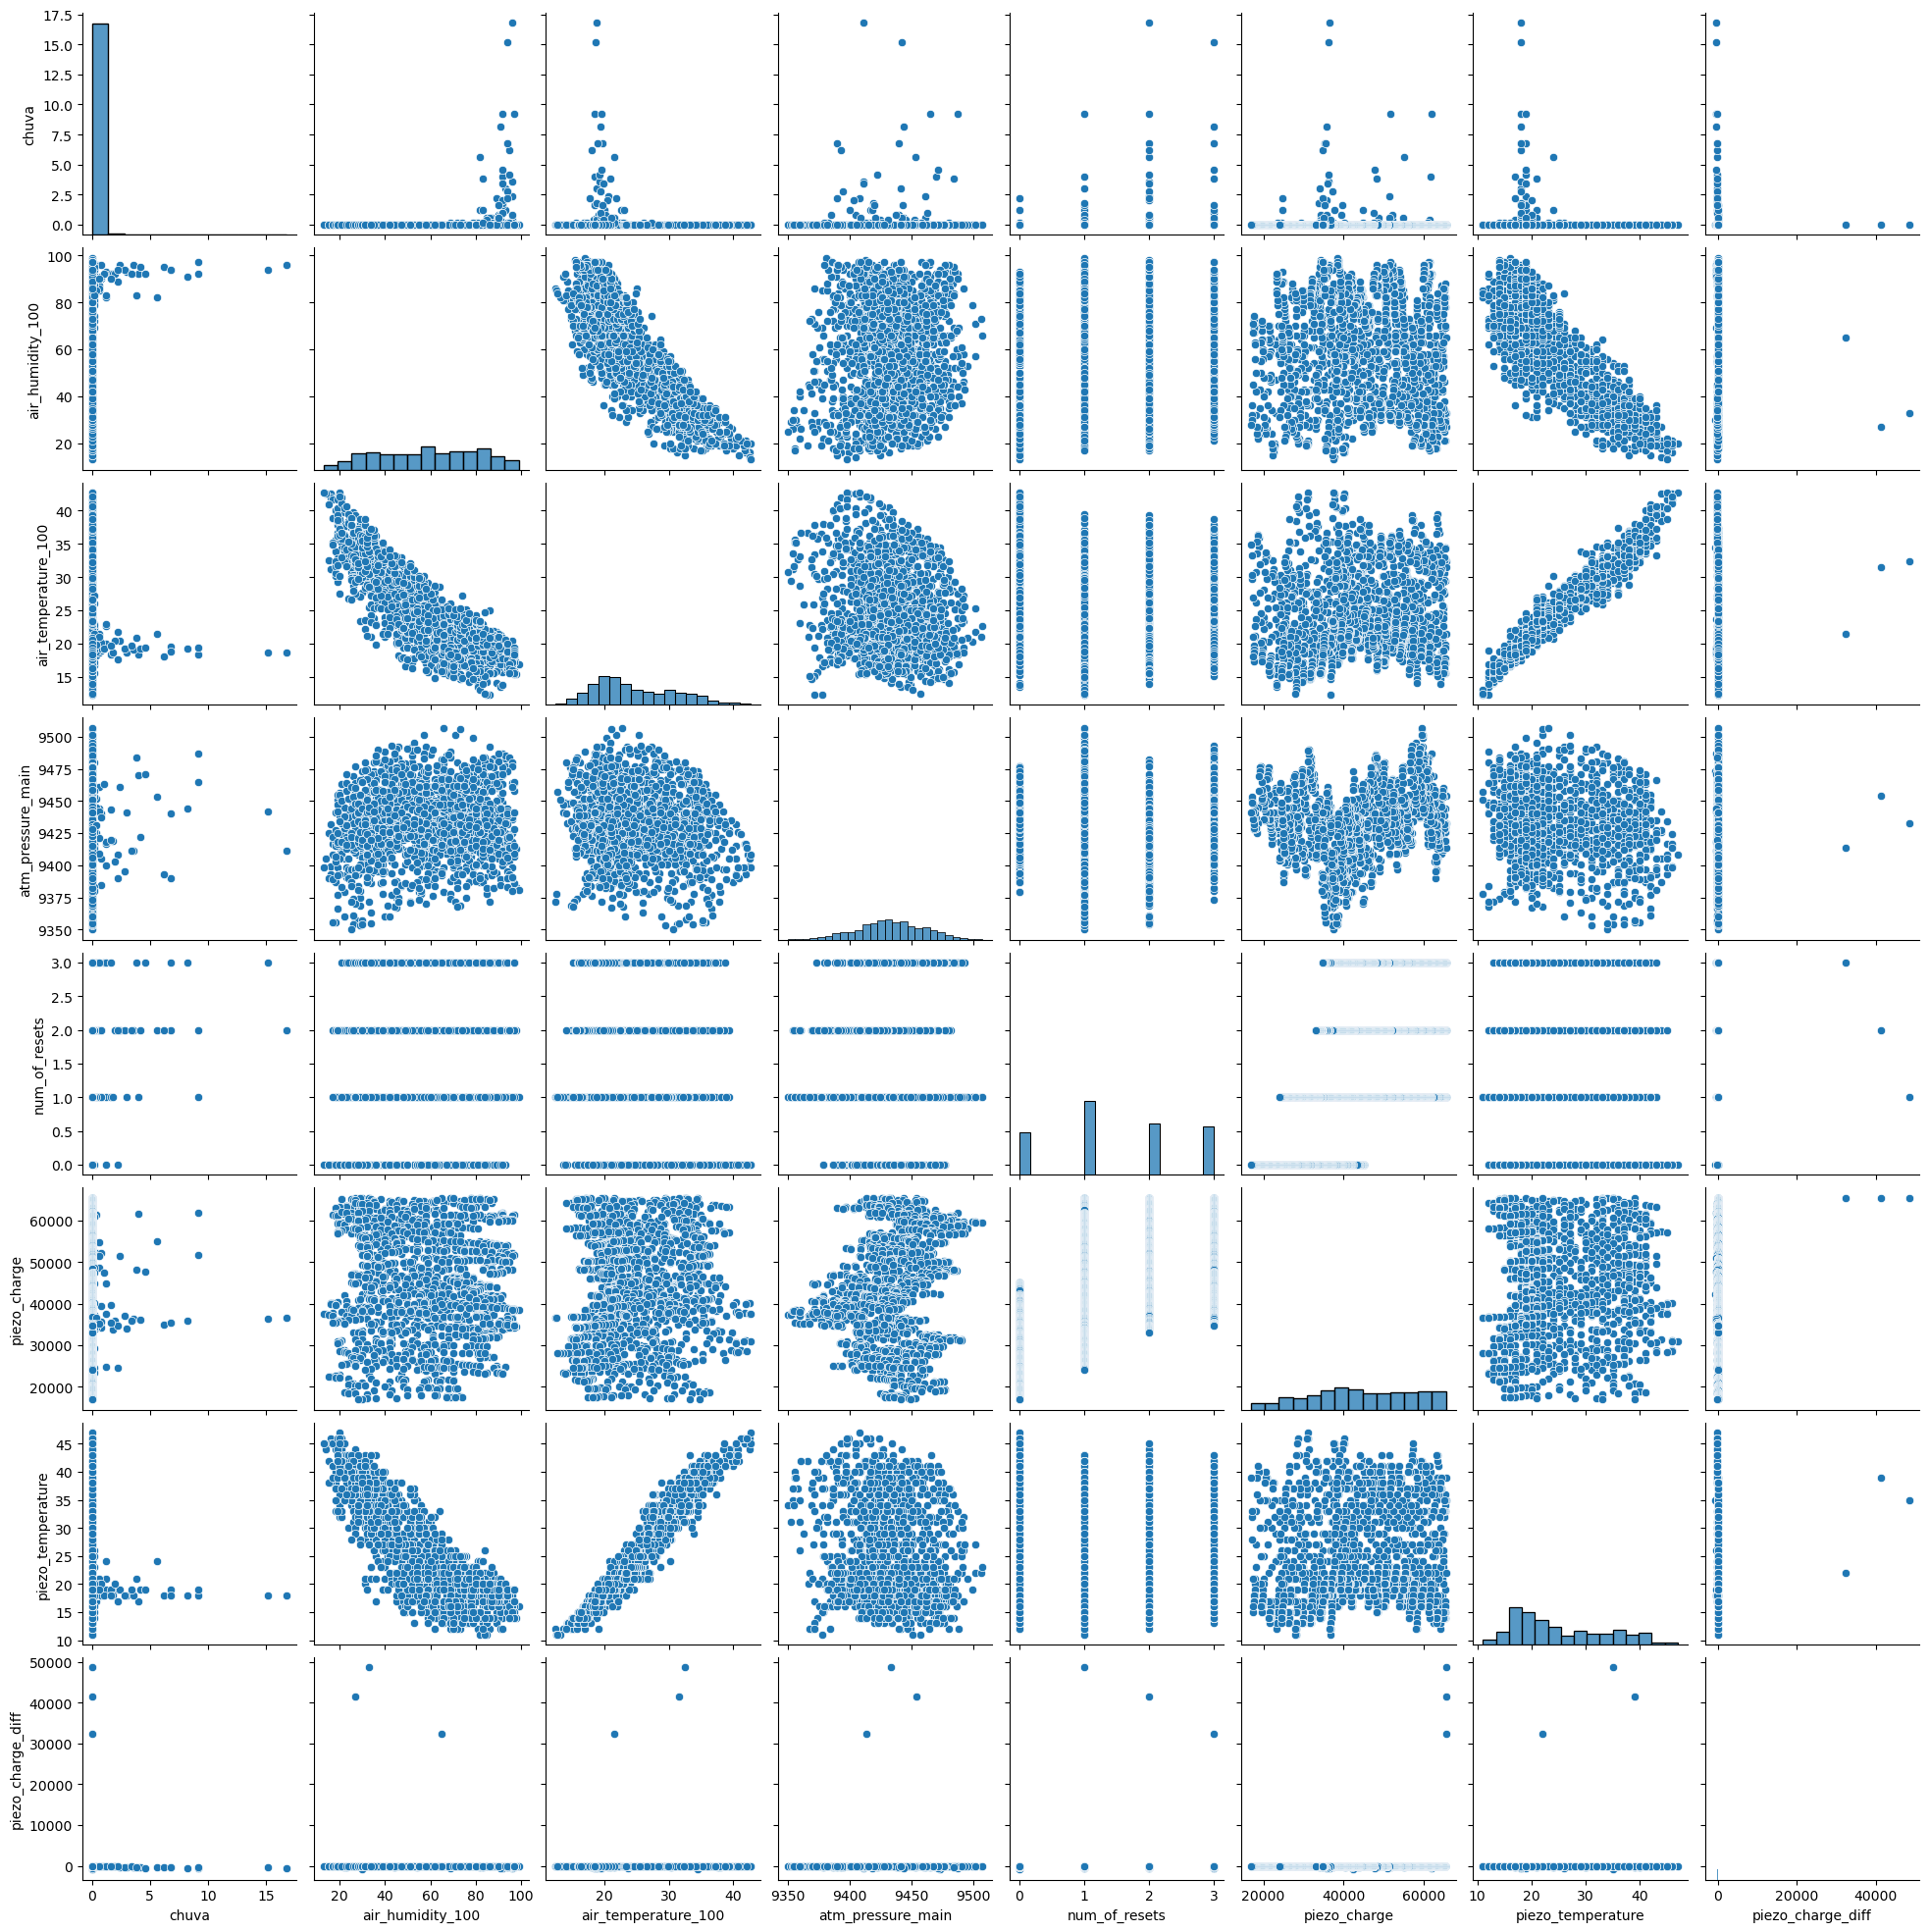

In [8]:
# Visualização das dispersões  
figsize=(15,10)
sns.pairplot(df)
plt.show

array([[<Axes: title={'center': 'chuva'}>,
        <Axes: title={'center': 'air_humidity_100'}>,
        <Axes: title={'center': 'air_temperature_100'}>],
       [<Axes: title={'center': 'atm_pressure_main'}>,
        <Axes: title={'center': 'num_of_resets'}>,
        <Axes: title={'center': 'piezo_charge'}>],
       [<Axes: title={'center': 'piezo_charge_diff'}>,
        <Axes: title={'center': 'piezo_temperature'}>, <Axes: >]],
      dtype=object)

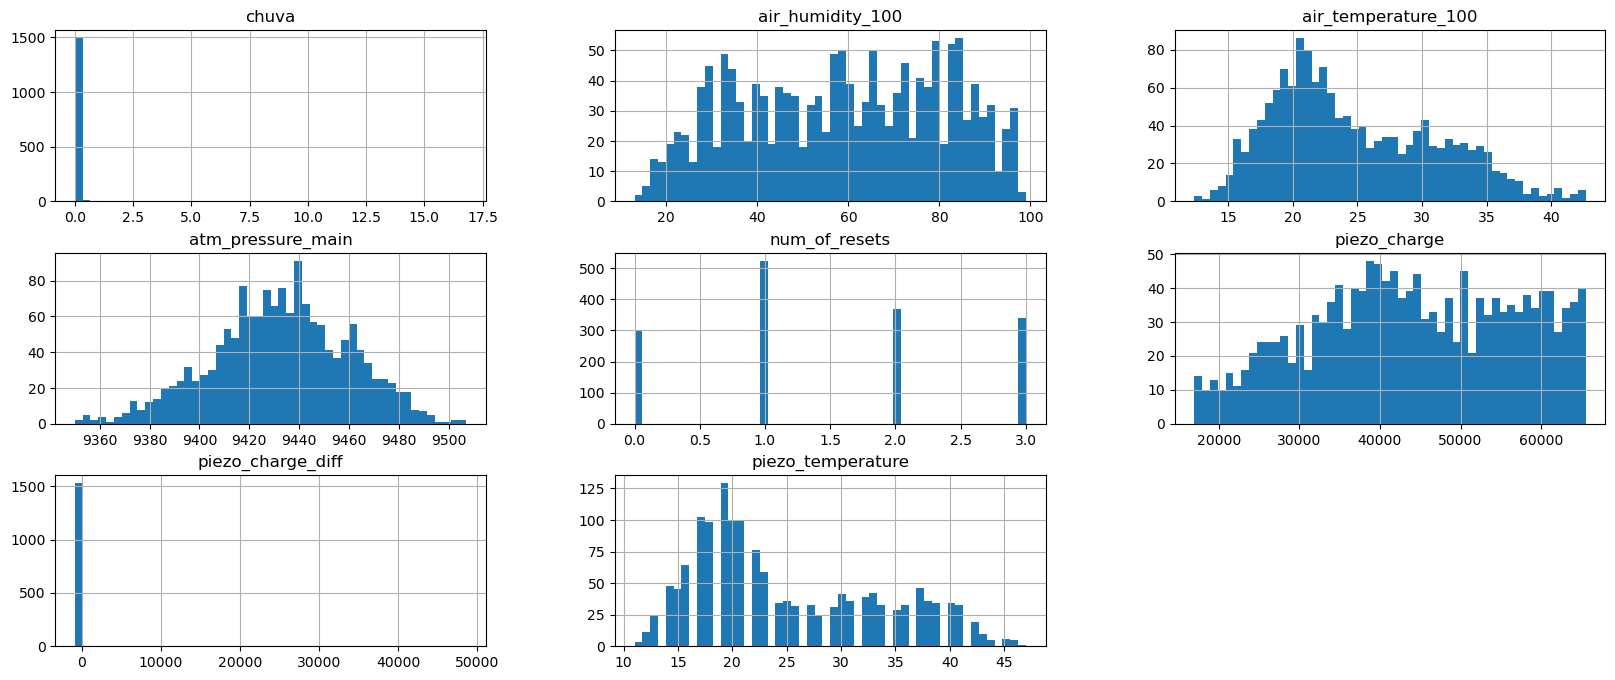

In [9]:
# Histogramas
df[['chuva', 'air_humidity_100', 'air_temperature_100', 'atm_pressure_main', 'num_of_resets', 
    'piezo_charge', 'piezo_charge_diff', 'piezo_temperature']].hist(figsize=(20,8), bins=50)

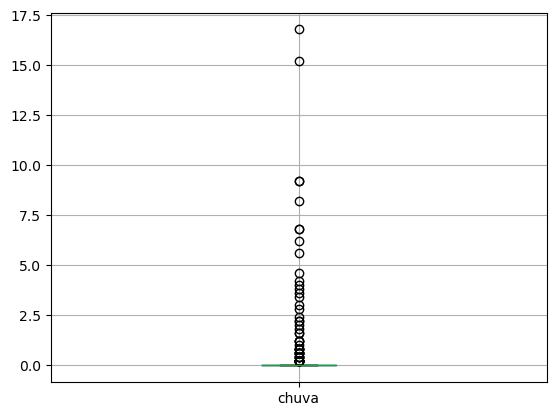

In [10]:
# Boxplot para analisar outliers. Necessário entendimento com área técnica sobre se é necessário eliminar.
df.boxplot(['chuva'])

Q1 = df['chuva'].quantile(0.25)
Q3 = df['chuva'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

#Necessário entendimento vertical sobre outliers para aplicação do melhor critério
#filter = (df['chuva'] >= Q1 - 1.5 * IQR) & (df['chuva'] <= Q3 + 1.5 *IQR)
#df = df.loc[filter]  

#Depois
#df.boxplot(['chuva'])

<Axes: >

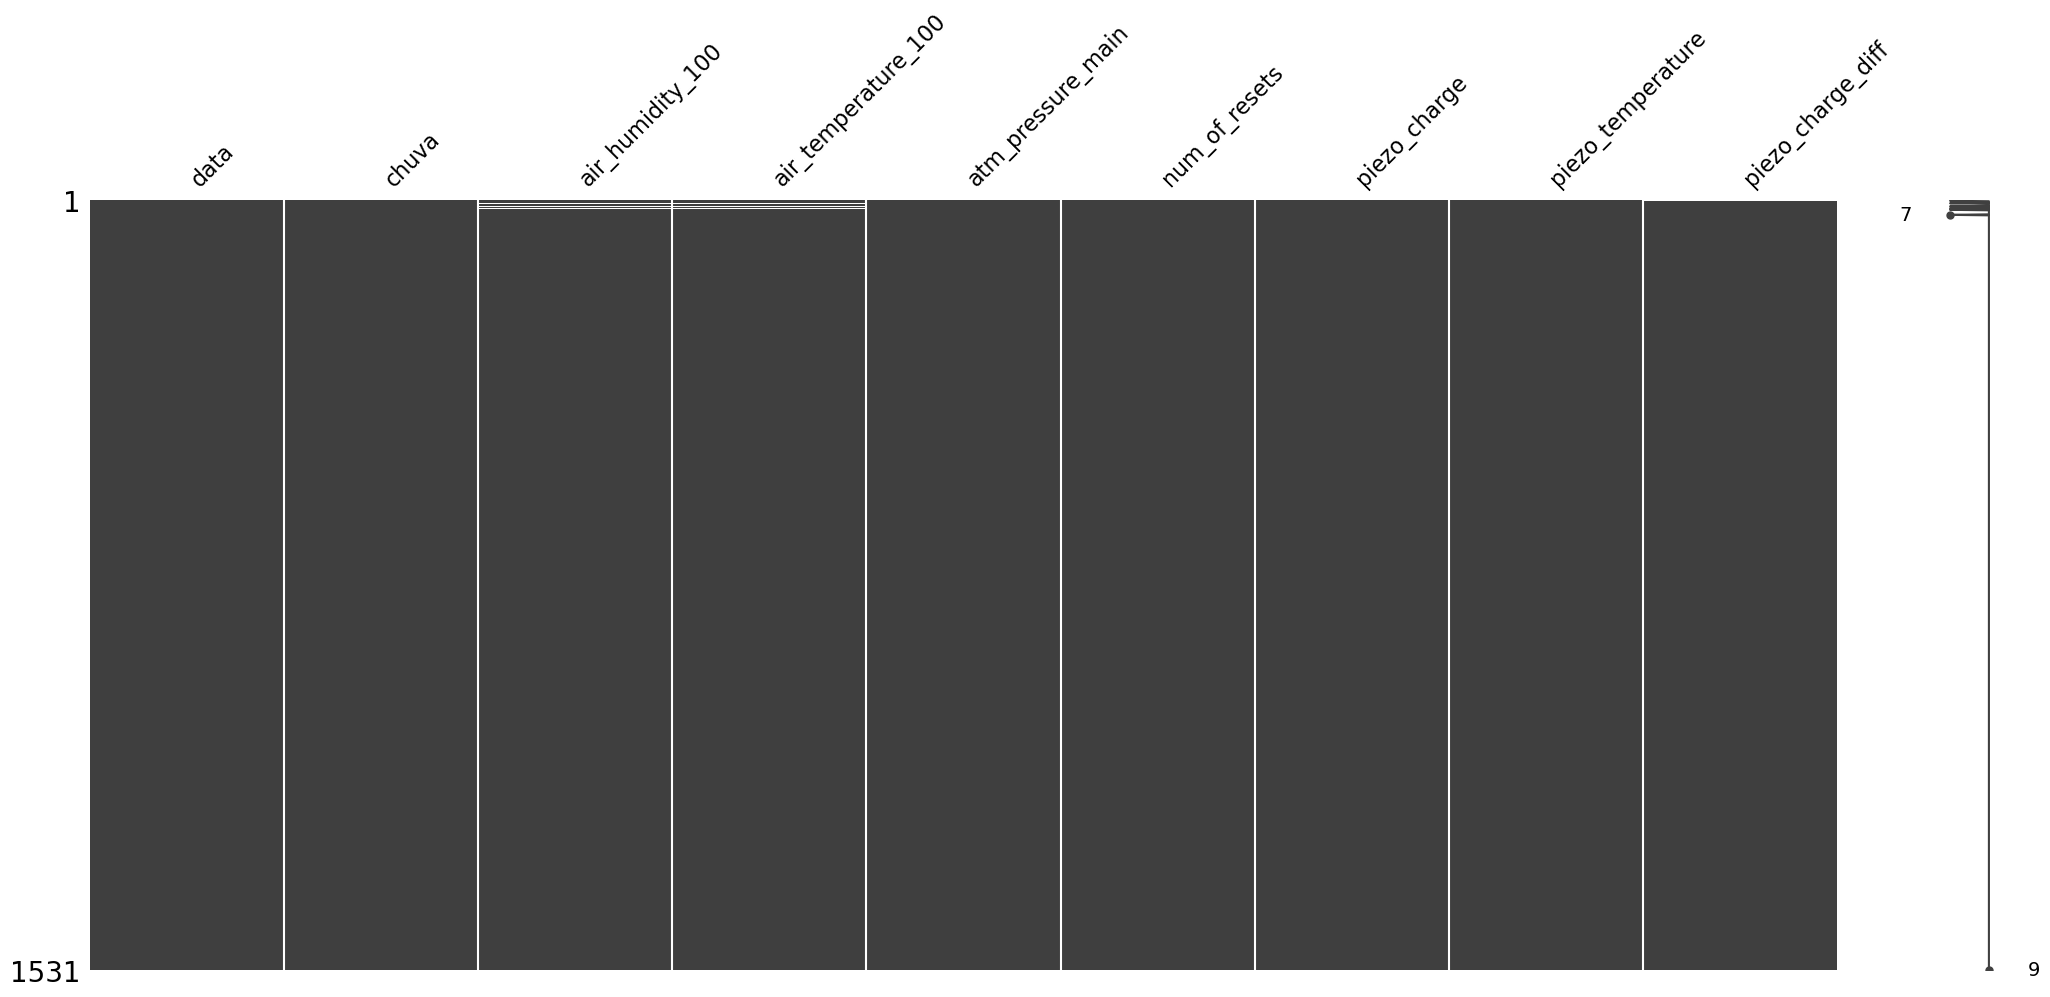

In [11]:
# Visualizando missing values
msno.matrix(df)

In [12]:
#Apenas um registro encontrado. Abordagem: imputação por KNN
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df['air_temperature_100'] = knn_imputer.fit_transform(df[['air_temperature_100']])
df['air_humidity_100'] = knn_imputer.fit_transform(df[['air_humidity_100']])
df['air_temperature_100'].isnull().sum()
df['air_humidity_100'].isnull().sum()

0

In [13]:
#Ação e análise alternativas: eliminar dias não chuvosos 
#Mesmo inflado de zeros, dias não chuvosos precisam ser considerados no modelo. Necessário entendimento com especialistas.

# Critério precisa ser melhor entendido com área técnica
filter = (df['chuva'] >= 0.05) 
df = df.loc[filter]  


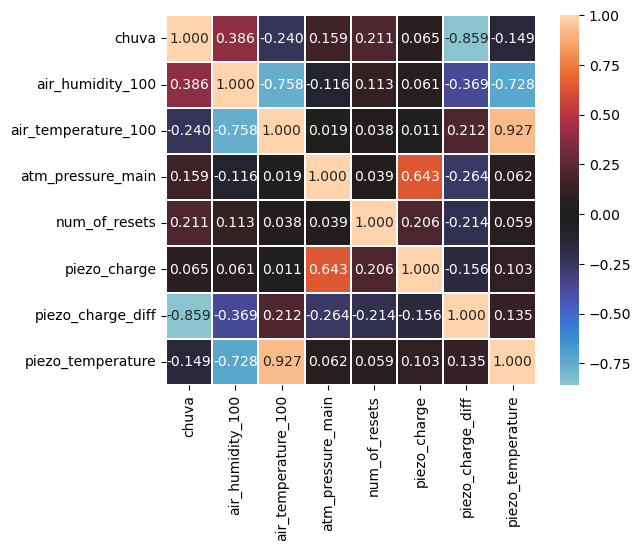

In [14]:
# Mapa de calor (correlações)

data_corr = df.loc[:,['chuva', 'air_humidity_100', 'air_temperature_100', 'atm_pressure_main', 'num_of_resets', 
                      'piezo_charge', 'piezo_charge_diff', 'piezo_temperature']]

matrix = data_corr.corr()

sns.heatmap(
        matrix,
        center=0,
        fmt='.3f',
        square=True,
        annot=True,
        linewidth=.3
    )
%matplotlib inline

O modelo é: Chuva = -1.253 + -0.022387X
R2:0.737


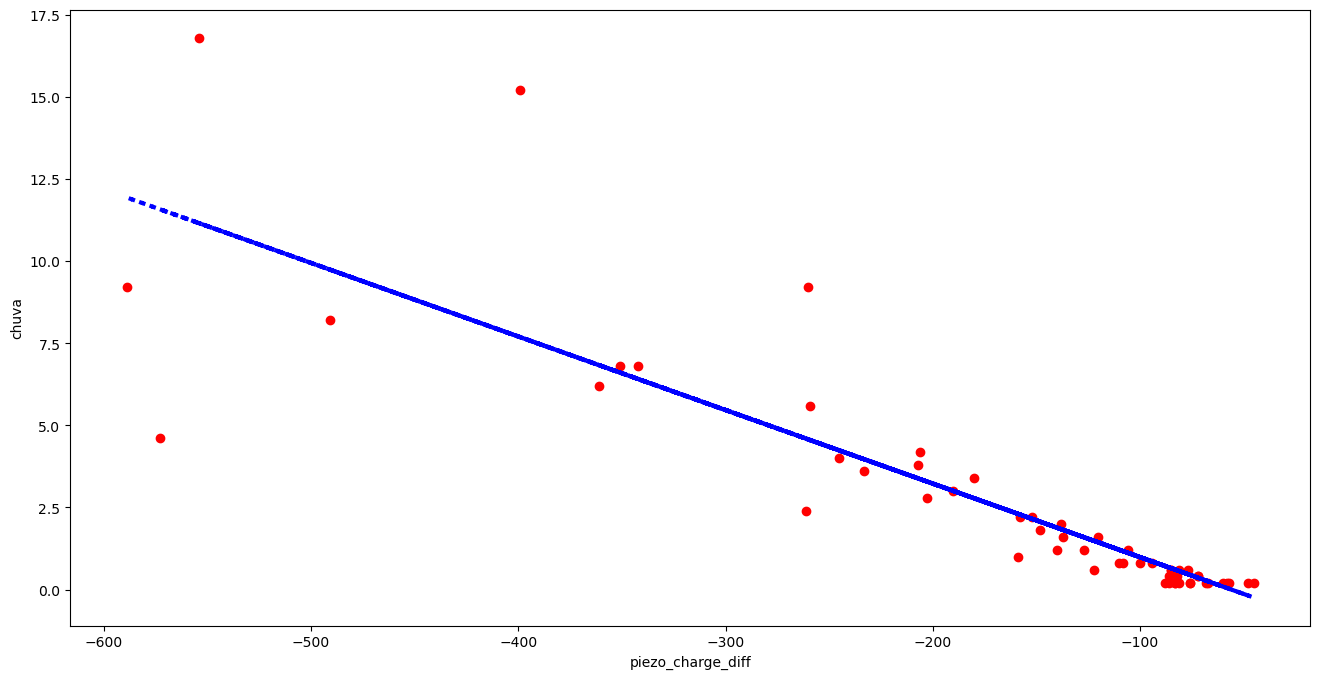

                            OLS Regression Results                            
Dep. Variable:                  chuva   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     148.9
Date:                Wed, 02 Aug 2023   Prob (F-statistic):           5.14e-17
Time:                        17:51:39   Log-Likelihood:                -110.93
No. Observations:                  55   AIC:                             225.9
Df Residuals:                      53   BIC:                             229.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.2530      0.40

In [15]:
# Regressão linear simples. A variável usada foi a 'piezo_charge_diff', que demonstrou a melhor correlação.
Depend = 'chuva'
Independ = 'piezo_charge_diff'

X = df[Independ].values.reshape(-1,1)
y = df[Depend].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(X, y)

r2 = reg.score(X, y)

print("O modelo é: Chuva = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
print("R2:"+str(round(r2,3)))

f_previsaoes = reg.predict(X)

plt.figure(figsize = (16,8))
plt.scatter(
    df[Independ], 
    df[Depend], 
    c='red')

plt.plot(
    df[Independ],
    f_previsaoes,
    c='blue',
    linewidth=3,
    linestyle=':'
)

plt.xlabel(Independ)
plt.ylabel(Depend)
plt.show()

X = df[Independ]
y = df[Depend]
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


In [16]:
Depend = 'chuva'
X = df.drop(['data','chuva'], axis=1)
y = df[Depend]

modelo = LinearRegression()
modelo.fit(X,y)
LinearRegression()

modelo.score(X,y)
modelo.intercept_
modelo.coef_

array([ 5.69636519e-02, -3.80657021e-01,  1.29845064e-03,  1.57557722e-01,
       -3.84405420e-05,  3.82857259e-01, -2.12068804e-02])

In [17]:
# Regressão Múltipla
X = df.drop(['data','chuva'], axis=1)
y = df[Depend]

y.count()

lm = pg.linear_regression(X, y, as_dataframe=True)
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-16.84,135.29,-0.12,0.90,0.76,0.72,-289.02,255.34
1,air_humidity_100,0.06,0.07,0.76,0.45,0.76,0.72,-0.09,0.21
2,air_temperature_100,-0.38,0.37,-1.03,0.31,0.76,0.72,-1.12,0.36
3,atm_pressure_main,0.00,0.01,0.09,0.93,0.76,0.72,-0.03,0.03
4,num_of_resets,0.16,0.30,0.53,0.60,0.76,0.72,-0.44,0.75
5,piezo_charge,-0.00,0.00,-0.99,0.33,0.76,0.72,-0.00,0.00
6,piezo_temperature,0.38,0.33,1.16,0.25,0.76,0.72,-0.28,1.05
7,piezo_charge_diff,-0.02,0.00,-9.24,0.00,0.76,0.72,-0.03,-0.02


In [18]:
lm1 = pg.linear_regression(X, y, as_dataframe=False)

print(lm1['df_model']) #graus de liberdade do modelo
print(lm1['df_resid']) #graus de liberdade dos resíduos

7
47


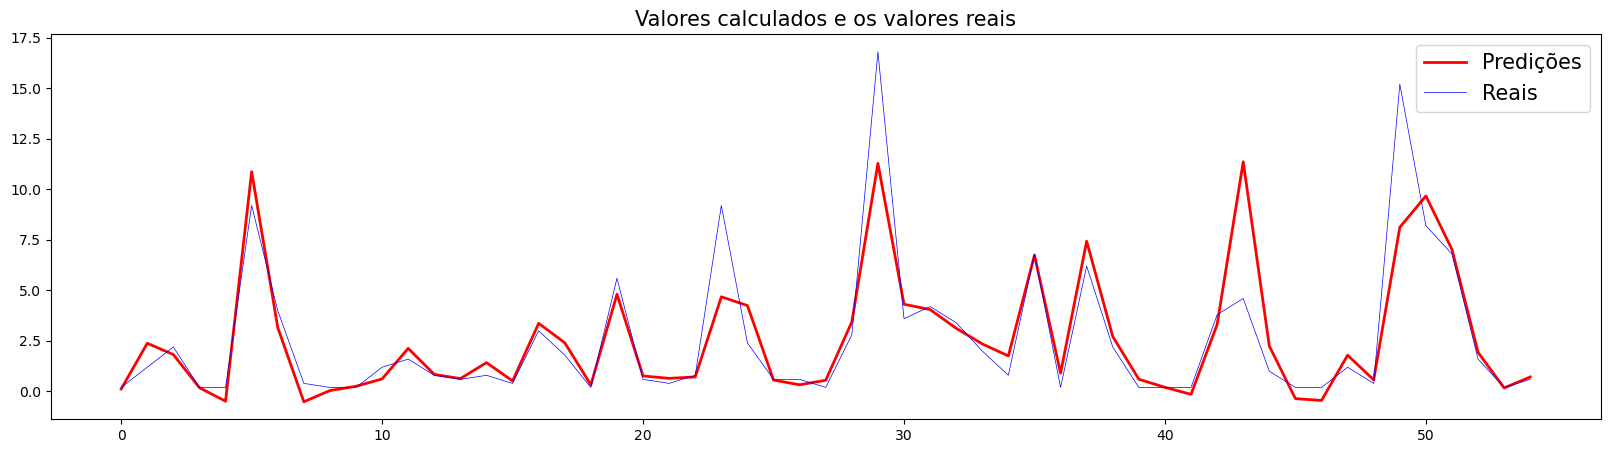

In [19]:
# Visualizando Predições X Reais
x = lm1['pred'].tolist()
Y = y.tolist()
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(x, linewidth=2, color='r')
plt.plot(Y, linewidth=0.5,color='b')
plt.title('Valores calculados e os valores reais',size=15)
plt.legend(['Predições','Reais'],fontsize=15)
plt.show()